# Principal Component Analysis (PCA)

PCA finds the directions in your data where the points are most spread out (maximum variance), allowing you to summarize high-dimensional data using just a few key axes of variation.


# Graphical Summary

![Fig](./graphical_summary/slides/Slide31.png)

# Key Formula

Let $\mathbf{X}$ be an $p \times N$ data matrix ($N$ observations, $p$ variables). The singular value decomposition of $\mathbf{X}$ can be written as

$$\mathbf{X} = \mathbf{U}\mathbf{S}\mathbf{V}^T$$

where:
- $\mathbf{U}$: $p \times p$ (orthogonal matrix, $\mathbf{U}^T\mathbf{U} = \mathbf{I}_p$)
- $\mathbf{S}$: $p \times p$ (diagonal matrix with singular values $s_1 \geq s_2 \geq \cdots \geq s_p \geq 0$)
- $\mathbf{V}$: $N \times p$ (orthonormal columns, $\mathbf{V}^T\mathbf{V} = \mathbf{I}_p$)

In PCA, we truncate to $k$ Components

$$\mathbf{X} = \mathbf{U}_k\mathbf{S}_k\mathbf{V}_k^T + \mathbf{U}_{\text{rest}}\mathbf{S}_{\text{rest}}\mathbf{V}_{\text{rest}}^T$$

where in the factor analysis formula:
- $\mathbf{L} = \mathbf{U}_k\mathbf{S}_k \quad (p \times k)$
  - $\mathbf{U}_k$: $p \times k$ (first $k$ columns of $\mathbf{U}$)
  - $\mathbf{S}_k$: $k \times k$ (first $k$ singular values, diagonal)
- $\mathbf{F} = \mathbf{V}_k^T \quad (k \times N)$
  - $\mathbf{V}_k$: $N \times k$ (first $k$ columns of $\mathbf{V}$)
- $\mathbf{E} = \mathbf{U}_{\text{rest}}\mathbf{S}_{\text{rest}}\mathbf{V}_{\text{rest}}^T \quad (p \times N)$ **reconstruction error** (truncation error). 
  - If all eigenvalues are used (i.e., $k=p$), then $\mathbf{E}=0$.


# Technical Details

## PCA and Factor Analysis

PCA can be considered as a special case of factor analysis with the following constraints:

1. **Orthonormal factor scores**: $Cov(\mathbf{F}) = \frac{1}{N}\mathbf{F}\mathbf{F}^T = \frac{1}{N}\mathbf{I}_k$

2. **Orthonormal loadings**: $\mathbf{L}^T\mathbf{L}=(\mathbf{U}_k\mathbf{S}_k )^T \mathbf{U}_k\mathbf{S}_k  = \mathbf{S}_k\mathbf{U}_k^T\mathbf{U}_k\mathbf{S}_k = \mathbf{\Lambda}_k$ (diagonal matrix of eigenvalues)

When conducting PCA, we order the eigenvalues by the variance: $\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_k$ to reach the **variance maximization** by selecting the **first** $k$ eigenvectors. 

Given $k$, the reconstruction error reaches mininmum  $\mathbf{E} = \arg\min ||\mathbf{X} - \mathbf{L}\mathbf{F}||_F^2$ subject to the constraints above.


## Variance Explained

- Total variance: $\text{tr}(\mathbf{S}) = \sum_{i=1}^P \lambda_i$
- Variance captured by $k$ components: $\sum_{i=1}^k \lambda_i$
- Proportion explained: $\frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^P \lambda_i}$


# Related Topics

- [Confounders](https://statfungen.github.io/statgen-prerequisites/confounder.html)
- [Genetic Relationship Matrix](https://statfungen.github.io/statgen-prerequisites/genetic_relationship_matrix.html)
- [Proportion of Variance Explained](https://statfungen.github.io/statgen-prerequisites/proportion_of_variance_explained.html)
- [Factor Analysis](https://statfungen.github.io/statgen-prerequisites/factor_analysis.html)

# Example


## Example 1: Detecting Multiple Ancestral Populations via PCA

You are given a sample of genotyped individuals and want to know: **Are all individuals in this sample from the same genetic ancestry, or do they come from different populations?** This is a fundamental question in population genetics and forensics, as population structure can be a major confounder in association studies.

In this example, we'll demonstrate how PCA can automatically reveal population structure without any prior knowledge of population labels.

This is the **mixture problem**: we have a mixture of individuals from distinct populations, and PCA reveals their structure through the principal components. This is fundamentally different from the admixture problem that we introduced in the topic of [Factor Analysis](https://statfungen.github.io/statgen-prerequisites/factor_analysis.html), where one individual could have ancestry from multiple populations. In Example 1, we focus on the **mixture problem**.

### Simulate Data from Two Populations

We'll create synthetic genotype data from two **distinct ancestral populations** with different allele frequencies at each marker. Then we'll combine these individuals into a single mixed sample.

In [13]:
rm(list=ls())
set.seed(72)

# ============================================================
# Simulate genotypes from two populations
# ============================================================

# Population 1: 50 individuals
# Population 2: 40 individuals
# Each with 100 SNPs

n_pop1 <- 50
n_pop2 <- 40
n_snps <- 100

# Allele frequency for Population 1
# High frequency for first half of SNPs, low for second half
p1 <- c(rep(0.85, 50), rep(0.15, 50))

# Allele frequency for Population 2  
# Opposite pattern: low for first half, high for second half
p2 <- c(rep(0.15, 50), rep(0.85, 50))

# Generate genotypes for Population 1
# Each individual has 2 alleles at each SNP, drawn from Binomial(2, p)
X_pop1 <- matrix(rbinom(n_pop1 * n_snps, size = 2, prob = p1), 
                  nrow = n_pop1, ncol = n_snps)
rownames(X_pop1) <- paste0("Ind_Pop1_", 1:n_pop1)
colnames(X_pop1) <- paste0("SNP", 1:n_snps)

# Generate genotypes for Population 2
X_pop2 <- matrix(rbinom(n_pop2 * n_snps, size = 2, prob = p2), 
                  nrow = n_pop2, ncol = n_snps)
rownames(X_pop2) <- paste0("Ind_Pop2_", 1:n_pop2)
colnames(X_pop2) <- paste0("SNP", 1:n_snps)

# Combine the two populations into a single sample
# This is the "mixture problem" - we have a mixture of individuals from two populations
X <- rbind(X_pop1, X_pop2)

cat("Combined sample size:", nrow(X), "individuals\n")
cat("Number of SNPs:", ncol(X), "\n")
cat("Population 1: samples 1 -", n_pop1, "\n")
cat("Population 2: samples", n_pop1+1, " -", nrow(X), "\n\n")

# Create population labels (only for visualization; in practice, these are unknown!)
pop_labels <- c(rep("Population 1", n_pop1), rep("Population 2", n_pop2))


Combined sample size: 90 individuals
Number of SNPs: 100 
Population 1: samples 1 - 50 
Population 2: samples 51  - 90 



### What We Can Observe

In practice, we only observe the **genotype matrix $\mathbf{X}$** (an $N \times P$ matrix of individual genotypes at $P$ SNPs). We do **not** know:
- Which individuals come from which population
- The true allele frequencies of each population  
- The number of populations in the mixture

Our goal is to use PCA on $\mathbf{X}$ to infer the population structure and identify which individuals belong together.

### Perform PCA on the Genotype Matrix

Now we apply PCA to the genotype matrix $\mathbf{X}$ to discover the population structure.

In [14]:
# Standardize the genotype matrix
X_standardized <- scale(X, center = TRUE, scale = TRUE)

# Perform PCA
pca_result <- prcomp(X_standardized, center = FALSE, scale. = FALSE)

# Extract principal component scores
pc_scores <- pca_result$x

# Calculate variance explained by each PC
variance_explained <- (pca_result$sdev^2) / sum(pca_result$sdev^2) * 100

cat("Variance explained by top 5 PCs:\n")
for (i in 1:5) {
  cat(sprintf("PC%d: %.2f%%\n", i, variance_explained[i]))
}
cat("\n")

Variance explained by top 5 PCs:
PC1: 27.12%
PC2: 14.60%
PC3: 5.47%
PC4: 3.64%
PC5: 2.31%



### Visualization: PC1 vs PC2 Colored by Population

We plot the first two principal components, coloring individuals by their true population origin (which PCA discovers automatically!).

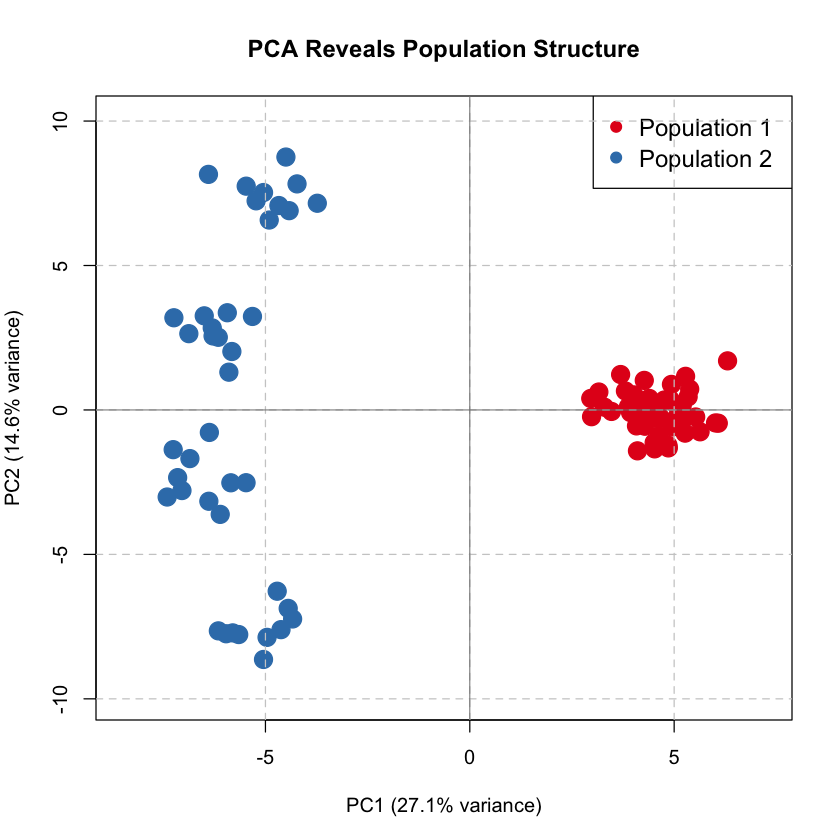

In [15]:
# Define colors for populations
pop_colors <- c("Population 1" = "#E41A1C", "Population 2" = "#377EB8")

# Create scatter plot: PC1 vs PC2
par(mfrow = c(1, 1), mar = c(5, 4, 4, 2))

plot(pc_scores[, 1], pc_scores[, 2],
     col = pop_colors[pop_labels],
     pch = 19, cex = 2,
     xlab = sprintf("PC1 (%.1f%% variance)", variance_explained[1]),
     ylab = sprintf("PC2 (%.1f%% variance)", variance_explained[2]),
     main = "PCA Reveals Population Structure",
     xlim = range(pc_scores[, 1]) * 1.15,
     ylim = range(pc_scores[, 2]) * 1.15)

legend("topright", 
       legend = names(pop_colors),
       col = pop_colors, 
       pch = 19, 
       cex = 1.2,
       bty = "o")

grid(col = "gray80", lty = 2)
abline(h = 0, col = "gray50", lty = 1, lwd = 0.8)
abline(v = 0, col = "gray50", lty = 1, lwd = 0.8)

### Scree Plot: Variance Explained

The scree plot shows that the first principal component captures the majority of variance, indicating strong population differentiation.

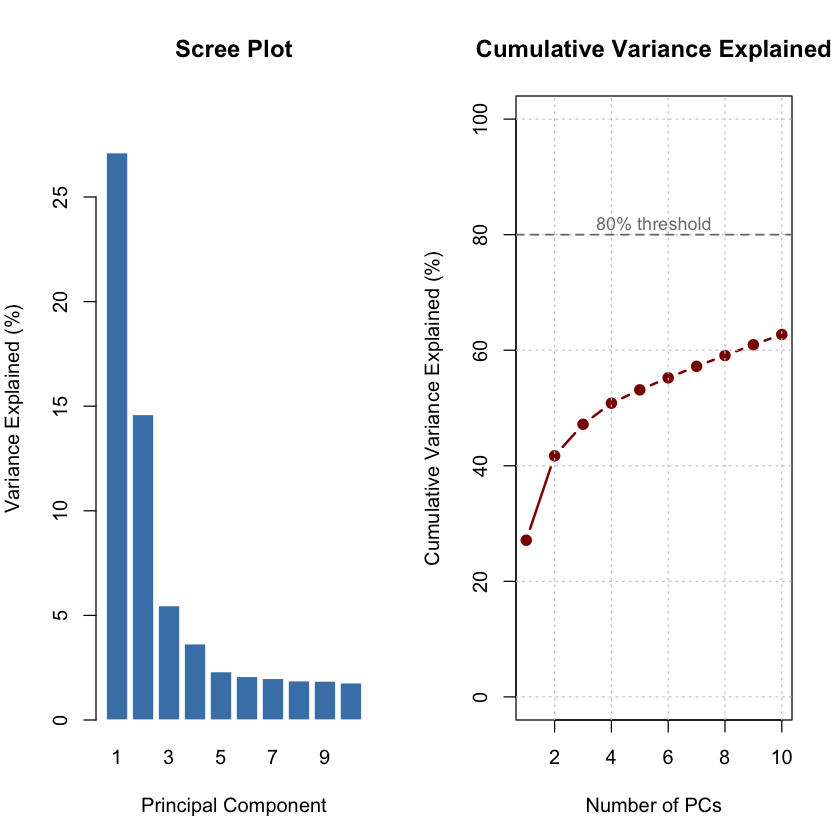

In [16]:
# Create scree plot
par(mfrow = c(1, 2), mar = c(5, 4, 4, 2))

# Barplot of variance explained
barplot(variance_explained[1:10],
        names.arg = 1:10,
        xlab = "Principal Component",
        ylab = "Variance Explained (%)",
        main = "Scree Plot",
        col = "steelblue",
        border = "white",
        ylim = c(0, max(variance_explained[1:10]) * 1.1))

# Cumulative variance explained
cumvar <- cumsum(variance_explained[1:10])
plot(1:10, cumvar,
     type = "b",
     pch = 19,
     col = "darkred",
     lwd = 2,
     xlab = "Number of PCs",
     ylab = "Cumulative Variance Explained (%)",
     main = "Cumulative Variance Explained",
     ylim = c(0, 100))
grid(col = "gray80")
abline(h = 80, col = "gray50", lty = 2, lwd = 1.5)
text(5.5, 82, "80% threshold", col = "gray50", cex = 0.9)

## Example 2: Admixture Analysis

PCA can also be used to solve **admixture problem**, which we have already introduced in [Factor Analysis](https://statfungen.github.io/statgen-prerequisites/factor_analysis.html). 

In this example, we'll apply PCA to admixed genotype data for visualization, but we recommend using the ADMIXTURE model for actual ancestry inference and estimation of individual ancestry proportions. We'll simulate genotype data for individuals with ancestry from two source populations (e.g., European and East Asian), then apply both PCA and compare it to the model-based approach of [Factor Analysis](https://statfungen.github.io/statgen-prerequisites/factor_analysis.html).

### Simulate Admixed Genotype Data

We'll create synthetic genotype data where we know the true ancestral populations and individual ancestry proportions.

In [17]:
rm(list=ls())
set.seed(74)

I <- 50  # Number of individuals
J <- 100  # Number of markers (SNPs)
K <- 2   # Number of ancestral populations

# Create L matrix with very distinct population frequencies
L_true <- matrix(0, nrow = J, ncol = K)

# Population 1: generally higher frequencies in the first 50 SNPS, lower frequencies in the last 50
L_true[1:50, 1] <- runif(50, 0.7, 0.95)
L_true[51:100, 1] <- runif(50, 0.05, 0.3)

# Population 2: inverse pattern
L_true[1:50, 2] <- runif(50, 0.05, 0.3)
L_true[51:100, 2] <- runif(50, 0.8, 0.95)

# Add row and column names
rownames(L_true) <- paste0("SNP", 1:J)
colnames(L_true) <- paste0("Pop", 1:K)
F_true <- matrix(0, nrow = K, ncol = I)

# Individuals 1-15: Pure Pop1
F_true[1, 1:15] <- 1.0
F_true[2, 1:15] <- 0.0

# Individuals 16-30: Pure Pop2
F_true[1, 16:30] <- 0.0
F_true[2, 16:30] <- 1.0

# Individuals 31-40: Pop1-Pop2 admixture (80-20)
F_true[1, 31:40] <- 0.8
F_true[2, 31:40] <- 0.2

# Individuals 41-50: Pop1-Pop2 admixture (30-70)
F_true[1, 41:50] <- 0.3
F_true[2, 41:50] <- 0.7

# Add row and column names
rownames(F_true) <- paste0("Pop", 1:K)
colnames(F_true) <- paste0("Ind", 1:I)

X_raw <- matrix(0, nrow = J, ncol = I)

for (i in 1:I) {
  for (j in 1:J) {
    # Expected frequency = weighted average of population frequencies
    p_ij <- sum(L_true[j, ] * F_true[, i])
    
    # Sample genotype (0, 1, or 2 copies)
    X_raw[j,i] <- rbinom(1, size = 2, prob = p_ij)
  }
}

# Add row and column names
rownames(X_raw) <- paste0("SNP", 1:J)
colnames(X_raw) <- paste0("Ind", 1:I)

print("A few rows for the generated raw genotype matrix X_raw:")
head(X_raw,3)

[1] "A few rows for the generated raw genotype matrix X_raw:"


,Ind1,Ind2,Ind3,Ind4,Ind5,Ind6,Ind7,Ind8,Ind9,Ind10,⋯,Ind41,Ind42,Ind43,Ind44,Ind45,Ind46,Ind47,Ind48,Ind49,Ind50
SNP1,2,2,1,2,2,2,2,1,2,2,⋯,0,1,1,0,0,2,1,0,1,1
SNP2,2,2,2,2,2,2,2,2,2,2,⋯,1,1,1,0,1,1,0,0,0,1
SNP3,2,1,1,1,2,1,1,2,2,2,⋯,1,0,1,0,0,1,1,1,0,2


In [18]:
# Normalize the genotype data
X <- scale(X_raw, center = TRUE, scale = TRUE)

### Perform PCA

In [19]:
# ============================================================
# Perform PCA to detect ancestry structure
# ============================================================

cat("\n============================================\n")
cat("Performing PCA on genotype data\n")
cat("============================================\n\n")

# Perform PCA on standardized genotypes
pca_result <- prcomp(t(X), center = FALSE, scale. = FALSE)

# Extract PC scores for each individual
pc_scores <- pca_result$x

# Calculate variance explained by each PC
variance_explained <- (pca_result$sdev^2) / sum(pca_result$sdev^2) * 100

cat("Variance explained by top 5 PCs:\n")
for (i in 1:5) {
  cat(sprintf("PC%d: %.2f%%\n", i, variance_explained[i]))
}
cat("\n")


Performing PCA on genotype data

Variance explained by top 5 PCs:
PC1: 47.83%
PC2: 3.50%
PC3: 3.46%
PC4: 3.06%
PC5: 2.47%



### Visualization

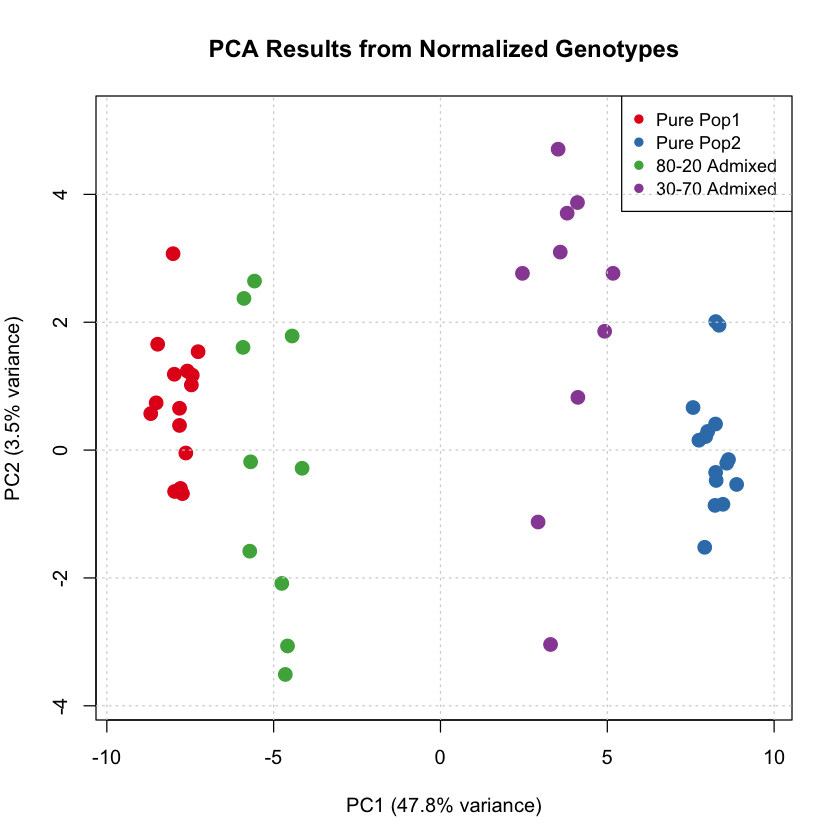

In [20]:
group_labels <- c(rep("Pure Pop1", 15),
                  rep("Pure Pop2", 15),
                  rep("80-20 Admixed", 10),
                  rep("30-70 Admixed", 10))

# Define colors for each group
group_colors <- c("Pure Pop1" = "#E41A1C",
                  "Pure Pop2" = "#377EB8",
                  "80-20 Admixed" = "#4DAF4A",
                  "30-70 Admixed" = "#984EA3")

# Create scatter plot: PC1 vs PC2
par(mfrow = c(1, 1), mar = c(5, 4, 4, 2))

plot(pc_scores[, 1], pc_scores[, 2],
     col = group_colors[group_labels],
     pch = 19, cex = 1.5,
     xlab = sprintf("PC1 (%.1f%% variance)", variance_explained[1]),
     ylab = sprintf("PC2 (%.1f%% variance)", variance_explained[2]),
     main = "PCA Results from Normalized Genotypes",
     xlim = range(pc_scores[, 1]) * 1.1,
     ylim = range(pc_scores[, 2]) * 1.1)

legend("topright", 
       legend = names(group_colors),
       col = group_colors, 
       pch = 19, 
       cex = 0.9,
       bty = "o")

grid()

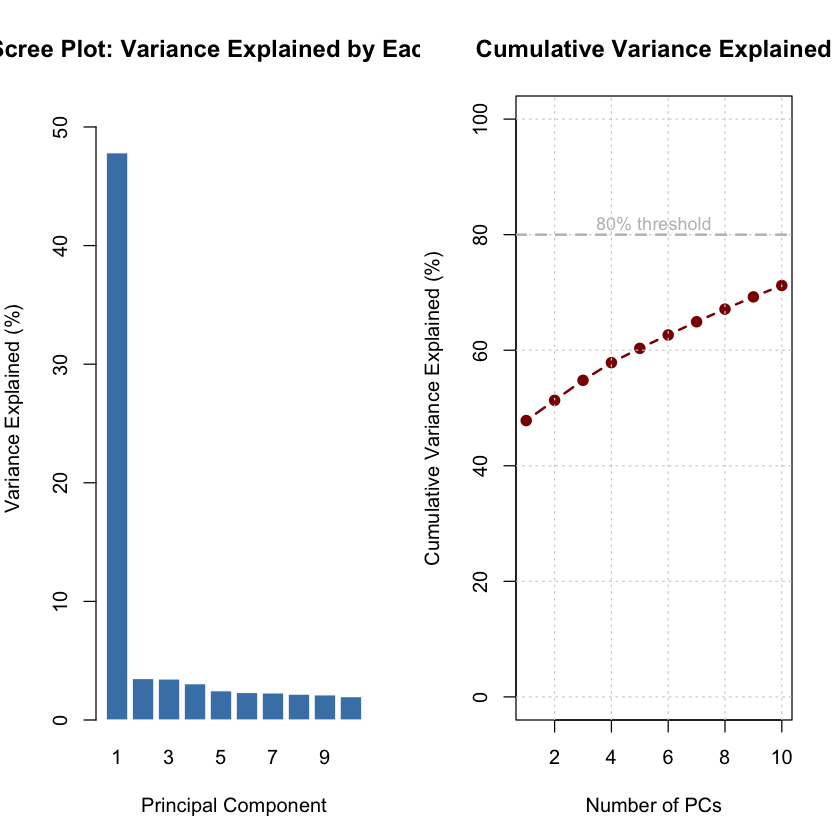

In [25]:
par(mfrow = c(1, 2), mar = c(5, 4, 4, 2))

# Create scree plot to show variance explained by each PC
# Barplot of variance explained
barplot(variance_explained[1:10],
        names.arg = 1:10,
        xlab = "Principal Component",
        ylab = "Variance Explained (%)",
        main = "Scree Plot: Variance Explained by Each PC",
        col = "steelblue",
        border = "white",
        ylim = c(0, max(variance_explained[1:10]) * 1.1))

# Cumulative variance explained
cumvar <- cumsum(variance_explained[1:10])
plot(1:10, cumvar,
     type = "b",
     pch = 19,
     col = "darkred",
     lwd = 2,
     xlab = "Number of PCs",
     ylab = "Cumulative Variance Explained (%)",
     main = "Cumulative Variance Explained",
     ylim = c(0, 100))
grid()

# Add reference line at 80% variance
abline(h = 80, col = "gray", lty = 2, lwd = 2)
text(5.5, 82, "80% threshold", col = "gray", cex = 0.9)

Each variant contribute to each PC to a different extent. Here we show the contribution to the first two PCs.

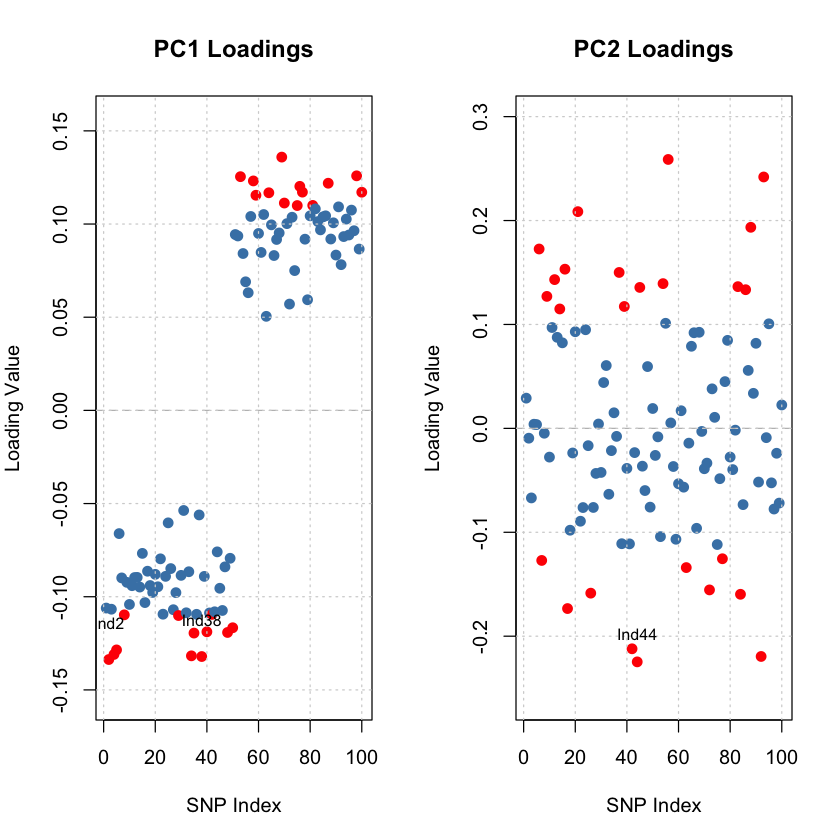

In [23]:
# Extract PC loadings (eigenvectors)
pc_loadings <- pca_result$rotation

# Get PC1 and PC2 loadings
pc1_loadings <- pc_loadings[, 1]
pc2_loadings <- pc_loadings[, 2]

par(mfrow = c(1, 2), mar = c(5, 4, 4, 2))

# Plot PC1 loadings
plot(1:J, pc1_loadings, 
     main = "PC1 Loadings",
     xlab = "SNP Index",
     ylab = "Loading Value",
     pch = 16,
     col = ifelse(abs(pc1_loadings) > quantile(abs(pc1_loadings), 0.75), 
                   "red", "steelblue"),
     cex = 1.2,
     ylim = range(pc1_loadings) * 1.15)
abline(h = 0, col = "gray", lty = 2)
grid()


# Highlight top SNPs by loading magnitude
top_indices <- order(abs(pc1_loadings), decreasing = TRUE)[1:3]
text(top_indices, pc1_loadings[top_indices] + 0.01, 
     colnames(X)[top_indices], cex = 0.8, pos = 3)

# Plot PC2 loadings
plot(1:J, pc2_loadings, 
     main = "PC2 Loadings",
     xlab = "SNP Index",
     ylab = "Loading Value",
     pch = 16,
     col = ifelse(abs(pc2_loadings) > quantile(abs(pc2_loadings), 0.75), 
                   "red", "steelblue"),
     cex = 1.2,
     ylim = range(pc2_loadings) * 1.15)
abline(h = 0, col = "gray", lty = 2)
grid()

# Highlight top SNPs by loading magnitude
top_indices_pc2 <- order(abs(pc2_loadings), decreasing = TRUE)[1:3]
text(top_indices_pc2, pc2_loadings[top_indices_pc2] + 0.01, 
     colnames(X)[top_indices_pc2], cex = 0.8, pos = 3)

Now we can attempt to infer the genetic ancestry using the PCA results. It's a heuristic that works well when:
- Population structure is the dominant source of variation (PC1 explains most variance)
- Populations are reasonably well-separated

In [29]:
# Find the range of PC1 scores
pc1_min <- min(pc_scores[, 1])
pc1_max <- max(pc_scores[, 1])

# Estimate ancestry proportions by rescaling PC1 to [0, 1]
# This assumes: Pop1 is at pc1_min, Pop2 is at pc1_max
# Ancestry proportion for Pop2 = (PC1_score - pc1_min) / (pc1_max - pc1_min)
ancestry_pop2_pca <- (pc_scores[, 1] - pc1_min) / (pc1_max - pc1_min)
ancestry_pop1_pca <- 1 - ancestry_pop2_pca

# Create a matrix similar to the ADMIXTURE F matrix
F_pca <- rbind(ancestry_pop1_pca, ancestry_pop2_pca)
rownames(F_pca) <- c("Pop1", "Pop2")
colnames(F_pca) <- colnames(X)

# Calculate correlation between true and PCA-inferred ancestry
cor_pop1 <- cor(F_true[1, ], F_pca[1, ])
cor_pop2 <- cor(F_true[2, ], F_pca[2, ])

cat("Correlation between true and PCA-inferred ancestry proportions:\n")
cat(sprintf("Population 1: %.4f\n", cor_pop1))
cat(sprintf("Population 2: %.4f\n", cor_pop2))
cat("\n")

Correlation between true and PCA-inferred ancestry proportions:
Population 1: 0.9962
Population 2: 0.9962



Since the correlations are all close to 1, there is no need to flip the populations.

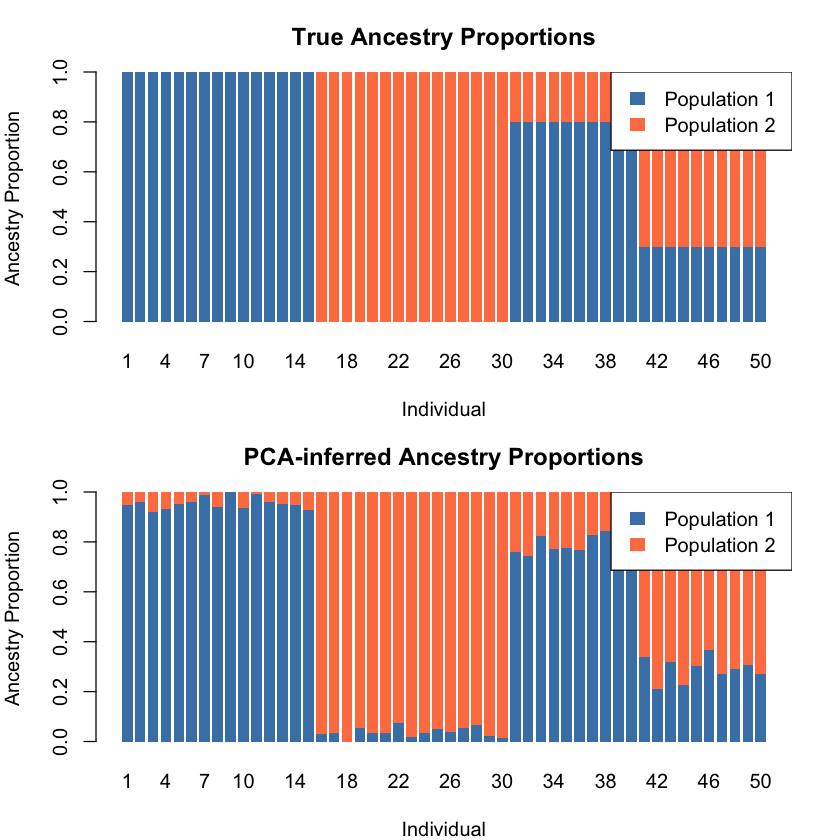

In [30]:
# Visualize the comparison using same style as ADMIXTURE
par(mfrow = c(2, 1), mar = c(4, 4, 3, 2))

# True ancestry
barplot(F_true, col = c("steelblue", "coral"), border = NA,
        main = "True Ancestry Proportions",
        xlab = "Individual", ylab = "Ancestry Proportion",
        names.arg = 1:I)
legend("topright", legend = c("Population 1", "Population 2"),
       fill = c("steelblue", "coral"), border = NA)

# PCA-inferred ancestry
barplot(F_pca, col = c("steelblue", "coral"), border = NA,
        main = "PCA-inferred Ancestry Proportions",
        xlab = "Individual", ylab = "Ancestry Proportion",
        names.arg = 1:I)
legend("topright", legend = c("Population 1", "Population 2"),
       fill = c("steelblue", "coral"), border = NA)

While PCA can visualize population structure, **for admixture analysis it is better to use the ADMIXTURE model** introduced in [Factor Analysis](https://statfungen.github.io/statgen-prerequisites/factor_analysis.html). Here's why:

- **PCA is a descriptive method**: PCA finds the directions of maximum variance in the data but does not provide a statistical model of how the data was generated. 
- **ADMIXTURE is a generative model**: ADMIXTURE explicitly models the genetic mixture as a weighted combination of ancestry components: $\mathbf{X} = \mathbf{LF} + \mathbf{E}$ (check [Factor Analysis](https://statfungen.github.io/statgen-prerequisites/factor_analysis.html) for more details).

# Supplementary

## Graphical Summary

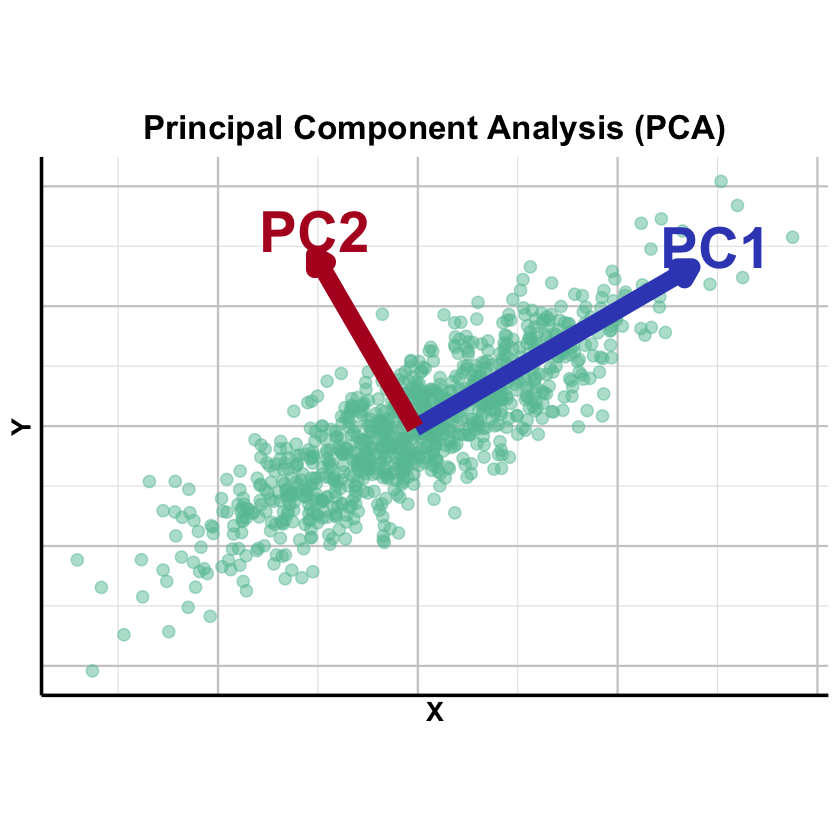

In [24]:
library(ggplot2)

# Set seed for reproducibility
set.seed(42)

# Generate correlated 2D data with PC1 >> PC2
n <- 1000
theta <- pi/6  # 30 degree tilt

# Create elongated cloud - PC1 much longer than PC2
x <- rnorm(n, 0, 3)    # Large variance for PC1 direction
y <- rnorm(n, 0, 0.8)  # Small variance for PC2 direction

# Rotate to create diagonal spread
X_original <- x * cos(theta) - y * sin(theta)
Y_original <- x * sin(theta) + y * cos(theta)

data <- data.frame(X = X_original, Y = Y_original)

# Perform PCA
pca <- prcomp(data, center = TRUE, scale. = FALSE)

# Get PC directions (eigenvectors) - flip if needed
pc1_direction <- -pca$rotation[, 1]  
pc2_direction <- -pca$rotation[, 2]  

# Scale for visualization
scale_factor1 <- 8
scale_factor2 <- 5
pc1_end <- scale_factor1 * pc1_direction
pc2_end <- scale_factor2 * pc2_direction

# Get the center (mean)
center_x <- mean(X_original)
center_y <- mean(Y_original)

# Create the plot
p_PCA <- ggplot(data, aes(x = X, y = Y)) +
  geom_point(color = "#66C2A5", alpha = 0.5, size = 3) +
  
  # PC1 arrow (blue) - use annotate instead of geom_segment
  annotate("segment", 
           x = center_x, y = center_y, 
           xend = center_x + pc1_end[1], 
           yend = center_y + pc1_end[2],
           arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
           color = "#3B4CC0", linewidth = 5) +
  annotate("text", x = center_x + pc1_end[1] + 0.6, 
           y = center_y + pc1_end[2] + 0.5, 
           label = "PC1", color = "#3B4CC0", size = 12, fontface = "bold") +
  
  # PC2 arrow (purple) - use annotate instead of geom_segment
  annotate("segment", 
           x = center_x, y = center_y, 
           xend = center_x + pc2_end[1], 
           yend = center_y + pc2_end[2],
           arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
           color = "#B40426", linewidth = 5) +
  annotate("text", x = center_x + pc2_end[1], 
           y = center_y + pc2_end[2] + 0.6, 
           label = "PC2", color = "#B40426", size = 12, fontface = "bold") +
  
  # Styling
  labs(title = "Principal Component Analysis (PCA)",
       x = "X", y = "Y") +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text = element_blank(),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_line(color = "gray90"),
    axis.line = element_line(color = "black", linewidth = 1),
    plot.background = element_rect(fill = "transparent", color = NA),
    panel.background = element_rect(fill = "transparent", color = NA)
  ) +
  coord_fixed(ratio = 1)
  
# Save with transparent background
ggsave("./cartoons/PCA.png", plot = p_PCA, width = 18, height = 12, 
       units = "in", dpi = 300, bg = "transparent")

print(p_PCA)